In [319]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.mixture import GaussianMixture

from clusterless import preprocess
from clusterless import viz
from clusterless import decoder

SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 30

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=BIGGER_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 5.)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

In [2]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016'

In [3]:
sorted_trials, good_sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=True,
    triage=False,
    good_units=True,
    thresholding=True
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = sorted[:,0]
spike_clusters = sorted[:,1]

sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=False
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

good_sorted = np.vstack([good_sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = good_sorted[:,0]
spike_clusters = good_sorted[:,1]

good_sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=False
)
print(f'good sorted neural data shape: {good_sorted_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
found 83 good ibl units ..
1st trial stim on time: 17.56, last trial stim on time 2310.24
sorted neural data shape: (265, 514, 30)
good sorted neural data shape: (265, 83, 30)


In [4]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24


In [5]:
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

In [6]:
thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

thresholded neural data shape: (265, 384, 30)


In [7]:
gmm_name = '../pretrained/danlab/Subjects/DY_016/best_bic_gmm'
means = np.load(gmm_name + '_means.npy')
covar = np.load(gmm_name + '_covariances.npy')
loaded_gmm = GaussianMixture(n_components=len(means), covariance_type='full')
loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
loaded_gmm.means_ = means
loaded_gmm.covariances_ = covar

spike_labels = loaded_gmm.predict(spike_features)
spike_probs = loaded_gmm.predict_proba(spike_features)

clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30,
    regional=True
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (265, 450, 30)


In [9]:
def plot_localization_features(
    data, 
    labels, 
    labels_display, 
    np1_channel_map,
    channels=[], 
    local=False,
    n_spikes=5_000, 
    figure_size=(8,16), 
    title='', 
):
    '''
    '''
    fig, axes = plt.subplots(1, 2, figsize=figure_size) 
    colors = [k for k,v in pltc.cnames.items()]
    random.shuffle(colors)
    for idx in labels_display:
        c = int(idx)
        if idx >= len(colors):
            c = c // 6  # only 148 colors available for plotting
            
        sub_data = data[labels == idx]
        x, z, maxptp = sub_data.T
        
        if len(sub_data) <= 2:
            continue
            
        if local:
            axes[0].scatter(x, z, s=.5, alpha=0.2, c=maxptp)
            axes[1].scatter(maxptp, z, s=.5, alpha=0.2, c=maxptp)
        else:
            axes[0].scatter(x[:n_spikes], z[:n_spikes], 
                            s=.5, alpha=0.05, c=maxptp[:n_spikes])
            axes[1].scatter(maxptp[:n_spikes], z[:n_spikes], 
                            s=.5, alpha=0.05, c=maxptp[:n_spikes])
            
        if local:
            axes[0].set_xlim(x.min()-25, x.max()+25)
            axes[0].set_ylim(z.min()-25, z.max()+25)
            axes[1].set_xlim(0, maxptp.max()+25)
            axes[1].set_ylim(z.min()-25, z.max()+25)
        else:    
            axes[0].set_xlim(-100, 175)
            axes[0].set_ylim(-80, 4000)
            axes[1].set_xlim(0, 60)
            axes[1].set_ylim(-80, 4000)
        
    if len(channels) > 0: 
        for channel in channels:
            axes[0].plot(np1_channel_map[int(channel), 0], 
                         np1_channel_map[int(channel), 1], 
                         markersize=3, c='orange', marker="s")
                
    axes[0].set_xlabel('x (um)')
    axes[0].set_ylabel('z (um)')
    axes[0].set_title(f'{title}')
    axes[1].set_xlabel('max ptp (amp)')
    axes[1].set_ylabel('z (um)')
    axes[1].set_title('')

    for ax in ['top','bottom','left','right']:
        axes[0].spines[ax].set_linewidth(1.5)
        axes[1].spines[ax].set_linewidth(1.5)

    plt.tight_layout()
    plt.show()

fig 1

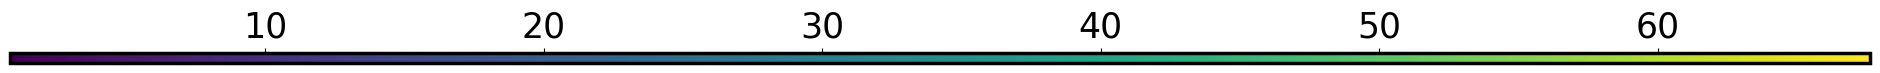

In [176]:
fig, ax = plt.subplots(1,1,figsize=(24,4))
im = ax.scatter(spike_features[:,1], spike_features[:,0], s=.5, alpha=1., c=spike_features[:,-1])
fig.gca().set_visible(False)
p0 = ax.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.5, p0[2]-p0[0], 0.025])
plt.colorbar(im, cax=ax_cbar, orientation='horizontal')
ax_cbar.xaxis.set_ticks_position('top')
# plt.savefig('cosyne_fig_1_panel_a_b_cbar.png', dpi=200)
plt.show()

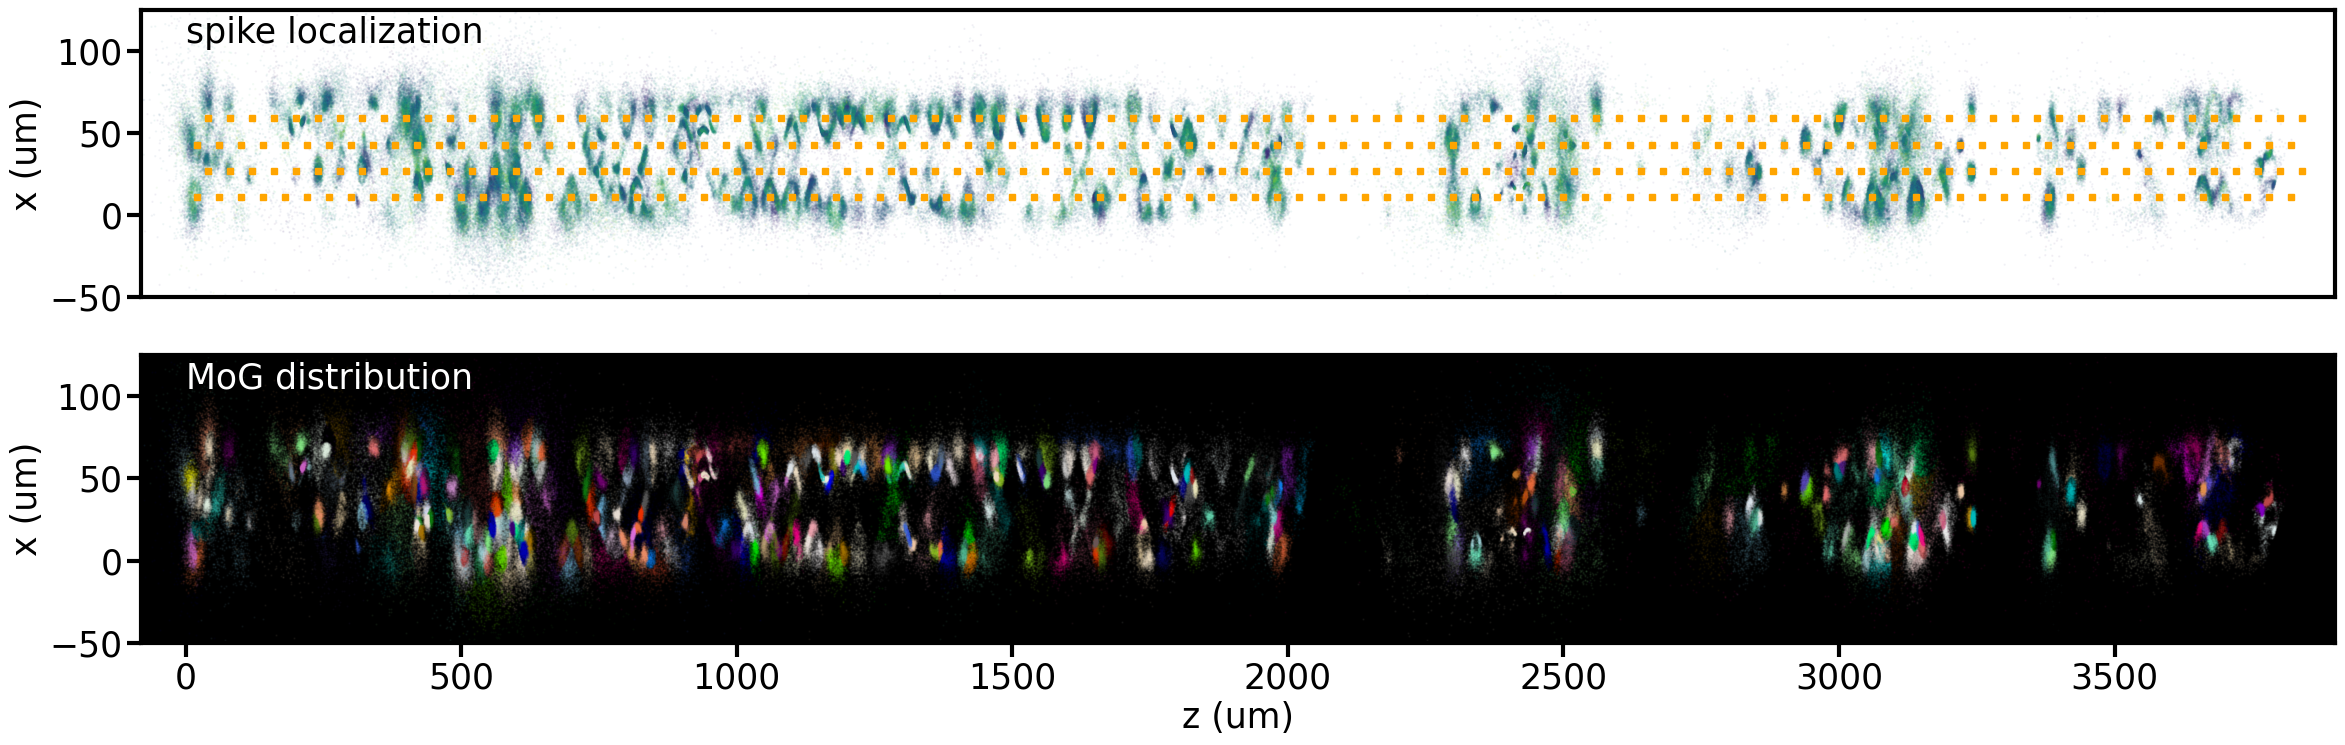

In [187]:
import matplotlib as mpl

fig = plt.figure(figsize=(24,8))

gs = GridSpec(2, 1) 
colors = [k for k,v in pltc.cnames.items()]
random.shuffle(colors)

ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:]) 

n_spikes = 1_000
channels = np.arange(384)
for idx in np.unique(spike_labels):
    c = int(idx)
    if idx >= len(colors):
        c = c // 6
        
    sub_data = spike_features[spike_labels == idx]
    x, z, maxptp = sub_data.T
    
    ax1.scatter(z[:n_spikes], x[:n_spikes], s=.5, alpha=0.05, c=maxptp[:n_spikes])
    ax2.scatter(z[:n_spikes], x[:n_spikes], s=.5, alpha=0.05, c=colors[c])
    
if len(channels) > 0: 
    for channel in channels:
        ax1.plot(np1_channel_map[int(channel), 1], np1_channel_map[int(channel), 0], 
                     markersize=5., c='orange', marker="s")
        # ax3.plot(np1_channel_map[int(channel), 0], np1_channel_map[int(channel), 1], 
        #              markersize=2.25, c='orange', marker="s")
        
ax1.text(0, 105, 'spike localization')
ax2.text(0, 105, 'MoG distribution', color='white')
        
ax1.set_ylim(-50, 125)
ax1.set_xlim(-80, 3900)
ax1.set_xticks([])
ax1.set_facecolor('white')
# plt.colorbar(ax=ax1, location='left')
ax2.set_ylim(-50, 125)
ax2.set_xlim(-80, 3900)
ax2.set_facecolor('black')
ax2.set_xlabel('z (um)')
ax1.set_ylabel('x (um)')
ax2.set_ylabel('x (um)')

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', length=10, width=3)

plt.tight_layout()
plt.savefig('cosyne_fig_1_panel_a_b.png', dpi=1000)

/tmp/ipykernel_122084/2458445826.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


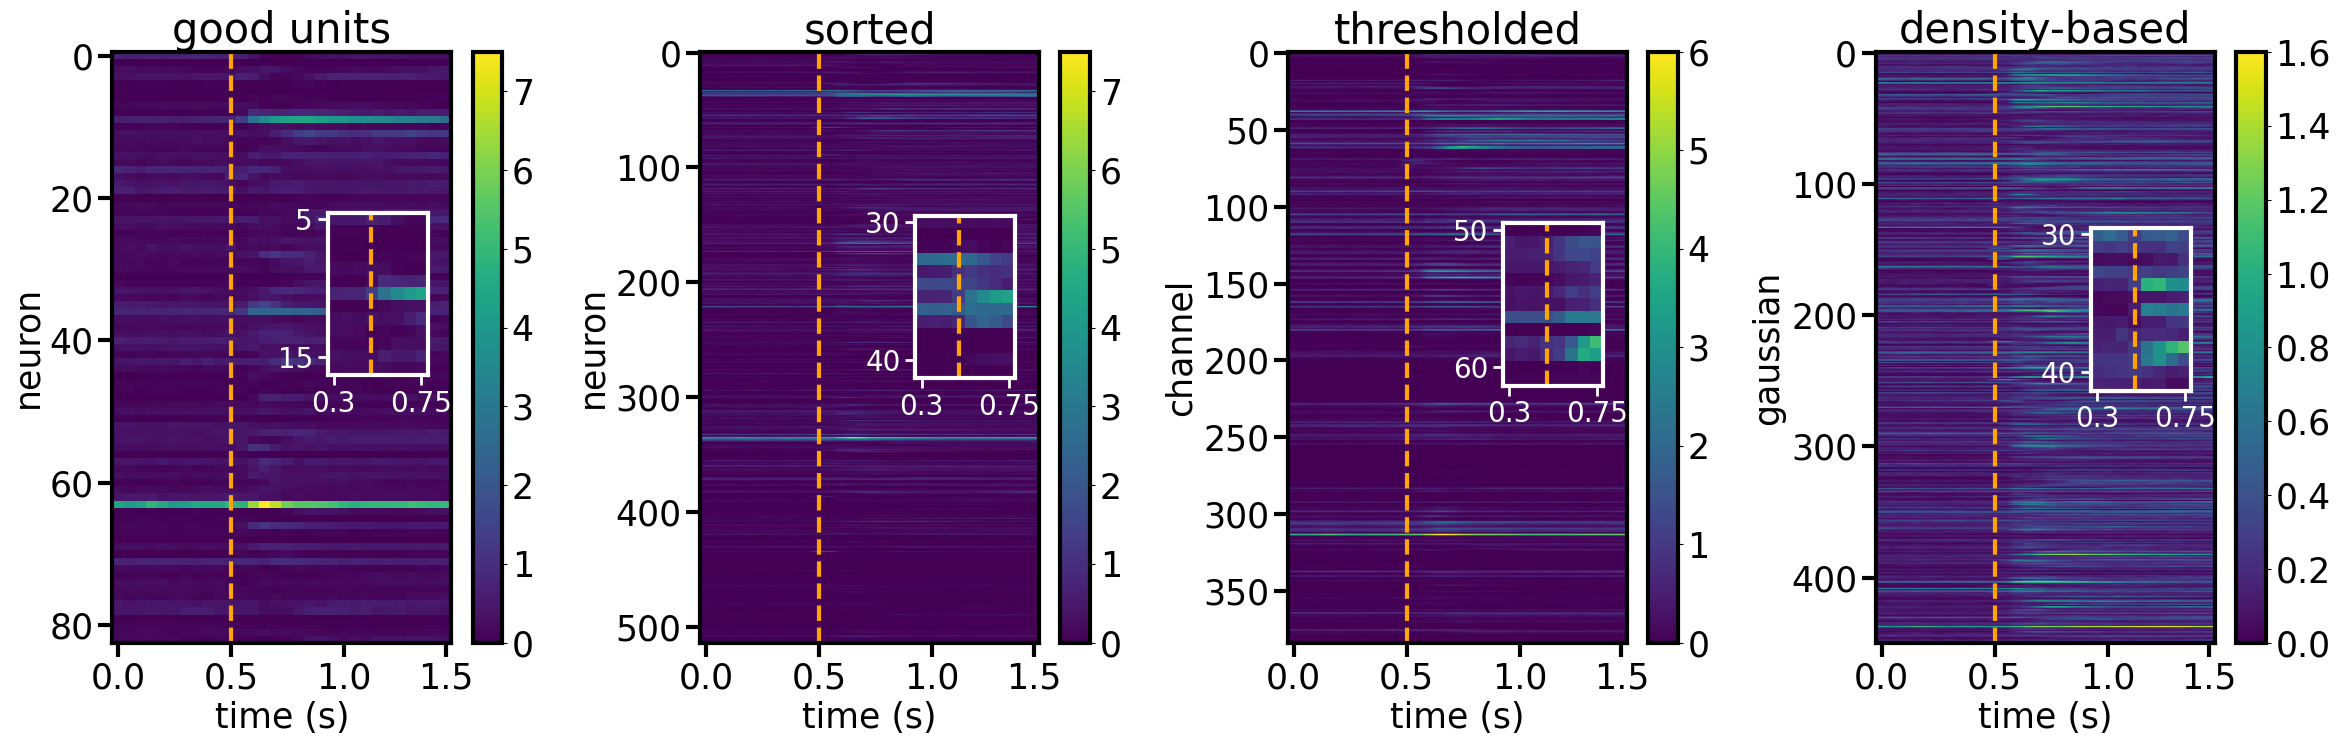

In [207]:
fig = plt.figure(figsize=(24,8))

gs = GridSpec(1, 4) 

ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[:,1]) 
ax3 = fig.add_subplot(gs[:,2]) 
ax4 = fig.add_subplot(gs[:,3]) 

p1 = ax1.imshow(good_sorted_neural_data.mean(0), aspect='auto', cmap='viridis', vmin=0, vmax=7.5)
ax1.axvline(10, color='orange', lw=3, linestyle='--')
ax1.set_title('good units')
ax1.set_xlabel('time (s)') 
ax1.set_ylabel('neuron')
ax1.set_xticks([0, 10, 20, 29], np.arange(0, 2., 0.5))
plt.colorbar(p1, ax=ax1);  

p2 = ax2.imshow(sorted_neural_data.mean(0), aspect='auto', cmap='viridis', vmin=0, vmax=7.5)
ax2.axvline(10, color='orange', lw=3, linestyle='--')
ax2.set_title('sorted')
ax2.set_xlabel('time (s)') 
ax2.set_ylabel('neuron')
ax2.set_xticks([0, 10, 20, 29], np.arange(0, 2., 0.5))
plt.colorbar(p2, ax=ax2); 
        
p3 = ax3.imshow(thresholded_neural_data.mean(0), aspect='auto', cmap='viridis', vmin=0, vmax=6.)
ax3.axvline(10, color='orange', lw=3, linestyle='--')
ax3.set_title('thresholded')
ax3.set_xlabel('time (s)') 
ax3.set_ylabel('channel')
ax3.set_xticks([0, 10, 20, 29], np.arange(0, 2., 0.5))
plt.colorbar(p3, ax=ax3);  # make color bars all same colorscale

p4 = ax4.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='viridis', vmin=0, vmax=1.6)
ax4.axvline(10, color='orange', lw=3, linestyle='--')
ax4.set_title('density-based')
ax4.set_xlabel('time (s)') 
ax4.set_ylabel('gaussian')
ax4.set_xticks([0, 10, 20, 29], np.arange(0, 2., 0.5))
plt.colorbar(p4, ax=ax4); 

for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='both', length=10, width=3)

# zoom insets 
inset_ax1 = inset_axes(ax1, width=1, height=2, bbox_transform=ax1.transData, bbox_to_anchor=(17,50), loc=3) 
inset_ax1.imshow(good_sorted_neural_data.mean(0)[3:16,8:16], cmap='viridis', vmin=0, vmax=7.5)
inset_ax1.axvline(3., color='orange', lw=3, linestyle='--')
inset_ax1.set_xticks([0, 7.], [0.3, 0.75])
inset_ax1.set_yticks([0, 11], [5, 15])
inset_ax1.tick_params(axis='both', colors='white', length=7, width=2, labelsize=20)

inset_ax2 = inset_axes(ax2, width=1, height=2, bbox_transform=ax2.transData, bbox_to_anchor=(17,315), loc=3) 
inset_ax2.imshow(sorted_neural_data.mean(0)[30:43,8:16], cmap='viridis', vmin=0, vmax=7.5)
inset_ax2.axvline(3., color='orange', lw=3, linestyle='--')
inset_ax2.set_xticks([0, 7.], [0.3, 0.75])
inset_ax2.set_yticks([0, 11], [30, 40])
inset_ax2.tick_params(axis='both', colors='white', length=7, width=2, labelsize=20)

inset_ax3 = inset_axes(ax3, width=1, height=2, bbox_transform=ax3.transData, bbox_to_anchor=(17,240), loc=3) 
inset_ax3.imshow(thresholded_neural_data.mean(0)[52:65,8:16], cmap='viridis', vmin=0, vmax=6.)
inset_ax3.axvline(3., color='orange', lw=3, linestyle='--')
inset_ax3.set_xticks([0, 7.], [0.3, 0.75])
inset_ax3.set_yticks([0, 11], [50, 60])
inset_ax3.tick_params(axis='both', colors='white', length=7, width=2, labelsize=20)

inset_ax4 = inset_axes(ax4, width=1, height=2, bbox_transform=ax4.transData, bbox_to_anchor=(17,285), loc=3) 
inset_ax4.imshow(clusterless_neural_data.mean(0)[32:45,8:16], cmap='viridis', vmin=0, vmax=1.6)
inset_ax4.axvline(3., color='orange', lw=3, linestyle='--')
inset_ax4.set_xticks([0, 7.], [0.3, 0.75])
inset_ax4.set_yticks([0, 11], [30, 40])
inset_ax4.tick_params(axis='both', colors='white', length=7, width=2, labelsize=20)

for inset_ax in [inset_ax1, inset_ax2, inset_ax3, inset_ax4]:
    for ax in ['bottom', 'top', 'right', 'left']:
        inset_ax.spines[ax].set_color('white')
        inset_ax.spines[ax].set_linewidth(3.)

plt.tight_layout()
plt.savefig('cosyne_fig_1_panel_c.png', dpi=600)

fig 2

fig 3

In [215]:
behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
motion_energy, wheel_velocity, wheel_speed, paw_speed, _, _ = preprocess.preprocess_dynamic_behaviors(behave_dict)

In [189]:
windowed_sorted_neural_data, half_window_size, n_windows = decoder.sliding_window(
    sorted_neural_data, 
    n_trials,
    window_size = 7
)

In [190]:
windowed_thresholded_neural_data, half_window_size, n_windows = decoder.sliding_window(
    thresholded_neural_data, 
    n_trials,
    window_size = 7
)

In [191]:
windowed_clusterless_neural_data, half_window_size, n_windows = decoder.sliding_window(
    clusterless_neural_data, 
    n_trials,
    window_size = 7
)

In [216]:
windowed_motion_energy = motion_energy[:,half_window_size:n_windows].reshape(-1,1)
windowed_wheel_velocity = wheel_velocity[:,half_window_size:n_windows].reshape(-1,1)
windowed_wheel_speed = wheel_speed[:,half_window_size:n_windows].reshape(-1,1)
windowed_paw_speed = paw_speed[:,half_window_size:n_windows].reshape(-1,1)

In [193]:
cv_r2s, cv_rmses, _, _, sorted_motion_energy = decoder.cv_decode_dynamic(
    windowed_sorted_neural_data,
    windowed_motion_energy,
    n_trials,
    'wheel speed'
)

wheel speed fold 1 test r2: 0.461 rmse: 4.274
wheel speed fold 2 test r2: 0.488 rmse: 4.003
wheel speed fold 3 test r2: 0.551 rmse: 3.674
wheel speed fold 4 test r2: 0.540 rmse: 3.931
wheel speed fold 5 test r2: 0.522 rmse: 4.073
wheel speed mean of 5-fold cv r2: 0.512 rmse: 3.991
wheel speed sd of 5-fold cv r2: 0.033 rmse: 0.196


In [194]:
cv_r2s, cv_rmses, _, _, sorted_wheel_speed = decoder.cv_decode_dynamic(
    windowed_sorted_neural_data,
    windowed_wheel_speed,
    n_trials,
    'wheel speed'
)

wheel speed fold 1 test r2: 0.469 rmse: 1.013
wheel speed fold 2 test r2: 0.499 rmse: 0.821
wheel speed fold 3 test r2: 0.488 rmse: 0.721
wheel speed fold 4 test r2: 0.422 rmse: 0.745
wheel speed fold 5 test r2: 0.488 rmse: 0.809
wheel speed mean of 5-fold cv r2: 0.473 rmse: 0.822
wheel speed sd of 5-fold cv r2: 0.027 rmse: 0.103


In [197]:
cv_r2s, cv_rmses, _, obs_motion_energy, clusterless_motion_energy = decoder.cv_decode_dynamic(
    windowed_clusterless_neural_data,
    windowed_motion_energy,
    n_trials,
    'motion energy'
)

motion energy fold 1 test r2: 0.468 rmse: 4.224
motion energy fold 2 test r2: 0.494 rmse: 3.953
motion energy fold 3 test r2: 0.537 rmse: 3.794
motion energy fold 4 test r2: 0.533 rmse: 3.995
motion energy fold 5 test r2: 0.509 rmse: 4.175
motion energy mean of 5-fold cv r2: 0.508 rmse: 4.028
motion energy sd of 5-fold cv r2: 0.025 rmse: 0.156


In [198]:
cv_r2s, cv_rmses, _, obs_wheel_speed, clusterless_wheel_speed = decoder.cv_decode_dynamic(
    windowed_clusterless_neural_data,
    windowed_wheel_speed,
    n_trials,
    'wheel speed'
)

wheel speed fold 1 test r2: 0.469 rmse: 1.013
wheel speed fold 2 test r2: 0.498 rmse: 0.822
wheel speed fold 3 test r2: 0.509 rmse: 0.690
wheel speed fold 4 test r2: 0.406 rmse: 0.765
wheel speed fold 5 test r2: 0.497 rmse: 0.795
wheel speed mean of 5-fold cv r2: 0.476 rmse: 0.817
wheel speed sd of 5-fold cv r2: 0.037 rmse: 0.107


In [257]:
rois = ['po', 'lp', 'dg', 'ca1', 'vis']

save_path = '../saved_results/danlab/Subjects/DY_016'

all_decode_results = np.load(
        f'{save_path}/static_behaviors/all_decode_results.npy', allow_pickle=True).item()
    
regional_decode_results = {
    rois[0]: np.load(
        f'{save_path}/static_behaviors/{rois[0]}_decode_results.npy', allow_pickle=True).item(),
    rois[1]: np.load(
        f'{save_path}/static_behaviors/{rois[1]}_decode_results.npy', allow_pickle=True).item(),     
    rois[2]: np.load(
        f'{save_path}/static_behaviors/{rois[2]}_decode_results.npy', allow_pickle=True).item(),
    rois[3]: np.load(
        f'{save_path}/static_behaviors/{rois[3]}_decode_results.npy', allow_pickle=True).item(),
    rois[4]: np.load(
        f'{save_path}/static_behaviors/{rois[4]}_decode_results.npy', allow_pickle=True).item()
}

idx = 1
behave_type = 'choice'
data_type = 'good units'
dy16_good_units = np.array([
    all_decode_results[behave_type][data_type][idx],
    regional_decode_results[rois[0]][behave_type][data_type][idx],
    regional_decode_results[rois[1]][behave_type][data_type][idx],
    regional_decode_results[rois[2]][behave_type][data_type][idx],
    # regional_decode_results[rois[3]][behave_type][data_type][idx],
    regional_decode_results[rois[4]][behave_type][data_type][idx]
])

data_type = 'sorted'
dy16_sorted = np.array([
    all_decode_results[behave_type][data_type][idx],
    regional_decode_results[rois[0]][behave_type][data_type][idx],
    regional_decode_results[rois[1]][behave_type][data_type][idx],
    regional_decode_results[rois[2]][behave_type][data_type][idx],
    # regional_decode_results[rois[3]][behave_type][data_type][idx],
    regional_decode_results[rois[4]][behave_type][data_type][idx]
])
    
data_type = 'thresholded'
dy16_thresholded = np.array([
    all_decode_results[behave_type][data_type][idx],
    regional_decode_results[rois[0]][behave_type][data_type][idx],
    regional_decode_results[rois[1]][behave_type][data_type][idx],
    regional_decode_results[rois[2]][behave_type][data_type][idx],
    # regional_decode_results[rois[3]][behave_type][data_type][idx],
    regional_decode_results[rois[4]][behave_type][data_type][idx]
])
    
data_type = 'clusterless'
dy16_clusterless = np.array([
    all_decode_results[behave_type][data_type][idx],
    regional_decode_results[rois[0]][behave_type][data_type][idx],
    regional_decode_results[rois[1]][behave_type][data_type][idx],
    regional_decode_results[rois[2]][behave_type][data_type][idx],
    # regional_decode_results[rois[3]][behave_type][data_type][idx],
    regional_decode_results[rois[4]][behave_type][data_type][idx]
])

In [261]:
save_path = '../saved_results/danlab/Subjects/DY_009'

all_decode_results = np.load(
        f'{save_path}/static_behaviors/all_decode_results.npy', allow_pickle=True).item()
    
regional_decode_results = {
    rois[0]: np.load(
        f'{save_path}/static_behaviors/{rois[0]}_decode_results.npy', allow_pickle=True).item(),
    rois[1]: np.load(
        f'{save_path}/static_behaviors/{rois[1]}_decode_results.npy', allow_pickle=True).item(),     
    rois[2]: np.load(
        f'{save_path}/static_behaviors/{rois[2]}_decode_results.npy', allow_pickle=True).item(),
    rois[3]: np.load(
        f'{save_path}/static_behaviors/{rois[3]}_decode_results.npy', allow_pickle=True).item(),
    rois[4]: np.load(
        f'{save_path}/static_behaviors/{rois[4]}_decode_results.npy', allow_pickle=True).item()
}

idx = 1
behave_type = 'choice'
data_type = 'good units'
dy09_good_units = np.array([
    all_decode_results[behave_type][data_type][idx],
    regional_decode_results[rois[0]][behave_type][data_type][idx],
    regional_decode_results[rois[1]][behave_type][data_type][idx],
    regional_decode_results[rois[2]][behave_type][data_type][idx],
    # regional_decode_results[rois[3]][behave_type][data_type][idx],
    regional_decode_results[rois[4]][behave_type][data_type][idx]
])

data_type = 'sorted'
dy09_sorted = np.array([
    all_decode_results[behave_type][data_type][idx],
    regional_decode_results[rois[0]][behave_type][data_type][idx],
    regional_decode_results[rois[1]][behave_type][data_type][idx],
    regional_decode_results[rois[2]][behave_type][data_type][idx],
    # regional_decode_results[rois[3]][behave_type][data_type][idx],
    regional_decode_results[rois[4]][behave_type][data_type][idx]
])
    
data_type = 'thresholded'
dy09_thresholded = np.array([
    all_decode_results[behave_type][data_type][idx],
    regional_decode_results[rois[0]][behave_type][data_type][idx],
    regional_decode_results[rois[1]][behave_type][data_type][idx],
    regional_decode_results[rois[2]][behave_type][data_type][idx],
    # regional_decode_results[rois[3]][behave_type][data_type][idx],
    regional_decode_results[rois[4]][behave_type][data_type][idx]
])
    
data_type = 'clusterless'
dy09_clusterless = np.array([
    all_decode_results[behave_type][data_type][idx],
    regional_decode_results[rois[0]][behave_type][data_type][idx],
    regional_decode_results[rois[1]][behave_type][data_type][idx],
    regional_decode_results[rois[2]][behave_type][data_type][idx],
    # regional_decode_results[rois[3]][behave_type][data_type][idx],
    regional_decode_results[rois[4]][behave_type][data_type][idx]
])

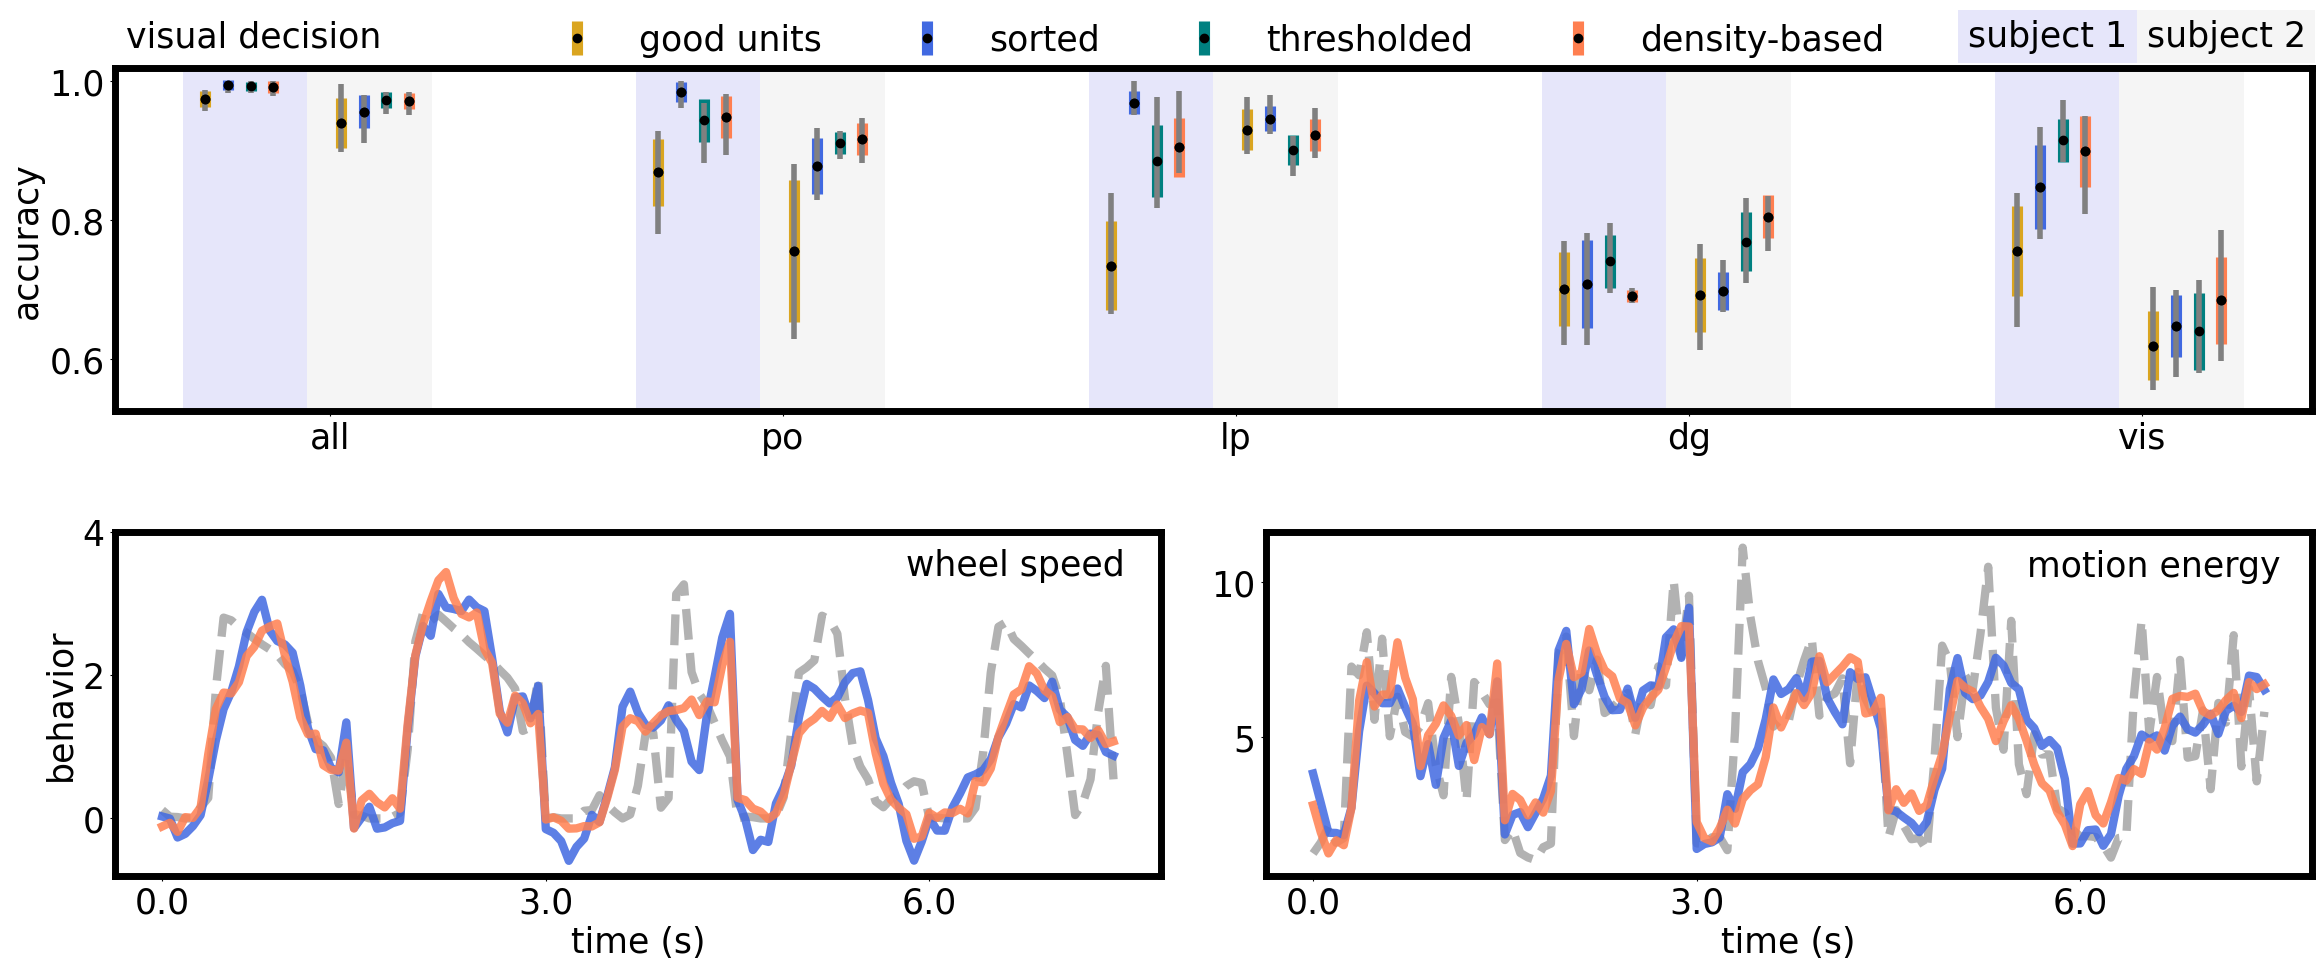

In [376]:
fig = plt.figure(figsize=(24,14))

gs = GridSpec(3, 2) 

ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,0]) 
ax3 = fig.add_subplot(gs[1,1]) 

ticks = ['po', 'lp', 'dg', 'vis']; ticks.insert(0, 'all')

mins, maxs, means, stds = dy16_good_units.min(1), dy16_good_units.max(1), dy16_good_units.mean(1), dy16_good_units.std(1)
ax1.errorbar(np.arange(len(ticks))*2-.2, means, stds, 
                 fmt='ok', ecolor='goldenrod', lw=8, label='good units')
ax1.errorbar(np.arange(len(ticks))*2-.2, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

mins, maxs, means, stds = dy09_good_units.min(1), dy09_good_units.max(1), dy09_good_units.mean(1), dy09_good_units.std(1)
ax1.errorbar(np.arange(len(ticks))*2-.8, means, stds, 
                 fmt='ok', ecolor='goldenrod', lw=8)
ax1.errorbar(np.arange(len(ticks))*2-.8, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

mins, maxs, means, stds = dy16_sorted.min(1), dy16_sorted.max(1), dy16_sorted.mean(1), dy16_sorted.std(1)
ax1.errorbar(np.arange(len(ticks))*2-.1, means, stds, 
                 fmt='ok', ecolor='royalblue', lw=8, label='sorted')
ax1.errorbar(np.arange(len(ticks))*2-.1, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

mins, maxs, means, stds = dy09_sorted.min(1), dy09_sorted.max(1), dy09_sorted.mean(1), dy09_sorted.std(1)
ax1.errorbar(np.arange(len(ticks))*2-.7, means, stds, 
                 fmt='ok', ecolor='royalblue', lw=8)
ax1.errorbar(np.arange(len(ticks))*2-.7, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

mins, maxs, means, stds = dy16_thresholded.min(1), dy16_thresholded.max(1), dy16_thresholded.mean(1), dy16_thresholded.std(1)
ax1.errorbar(np.arange(len(ticks))*2, means, stds, 
             fmt='ok', ecolor='teal', lw=8, label='thresholded')
ax1.errorbar(np.arange(len(ticks))*2, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=4)

mins, maxs, means, stds = dy09_thresholded.min(1), dy09_thresholded.max(1), dy09_thresholded.mean(1), dy09_thresholded.std(1)
ax1.errorbar(np.arange(len(ticks))*2-.6, means, stds, 
             fmt='ok', ecolor='teal', lw=8)
ax1.errorbar(np.arange(len(ticks))*2-.6, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=4)

mins, maxs, means, stds = dy16_clusterless.min(1), dy16_clusterless.max(1), dy16_clusterless.mean(1), dy16_clusterless.std(1)
ax1.errorbar(np.arange(len(ticks))*2+.1, means, stds, 
             fmt='ok', ecolor='coral', lw=8, label='density-based')
ax1.errorbar(np.arange(len(ticks))*2+.1, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

mins, maxs, means, stds = dy09_clusterless.min(1), dy09_clusterless.max(1), dy09_clusterless.mean(1), dy09_clusterless.std(1)
ax1.errorbar(np.arange(len(ticks))*2-.5, means, stds, 
             fmt='ok', ecolor='coral', lw=8)
ax1.errorbar(np.arange(len(ticks))*2-.5, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

ax1.legend(loc='lower left')
ax1.set_xticks([-.25, 1.75, 3.75, 5.75, 7.75], ticks)
ax1.set_xlim(-1.2, 8.5)
ax1.set_ylim(0.525, 1.02)
ax1.set_ylabel('accuracy')
ax1.text(-1.15, 1.05, 'visual decision')

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22),
          ncol=4, fancybox=False, shadow=False, frameon=False)

ax1.axvspan(-.9, -.35, facecolor='lavender')
ax1.axvspan(-.35, .2, facecolor='whitesmoke')
ax1.axvspan(1.1, 1.65, facecolor='lavender')
ax1.axvspan(1.65, 2.2, facecolor='whitesmoke')
ax1.axvspan(3.1, 3.65, facecolor='lavender')
ax1.axvspan(3.65, 4.2, facecolor='whitesmoke')
ax1.axvspan(5.1, 5.65, facecolor='lavender')
ax1.axvspan(5.65, 6.2, facecolor='whitesmoke')
ax1.axvspan(7.1, 7.65, facecolor='lavender')
ax1.axvspan(7.65, 8.2, facecolor='whitesmoke')

ax1.text(6.98, 1.05, 'subject 1', bbox={'facecolor': 'lavender', 'edgecolor':'none', 'pad':7})
ax1.text(7.77, 1.05, 'subject 2', bbox={'facecolor': 'whitesmoke', 'edgecolor':'none', 'pad':7})

ax2.plot(np.hstack([obs_wheel_speed[2][i] for i in range(0, 50, 10)]), alpha=.6, linewidth=6.,
         c='gray', linestyle='dashed', label='observed');
ax2.plot(np.hstack([sorted_wheel_speed[2].reshape(-1, 25)[i] for i in range(0, 50, 10)]), 
         c='royalblue', alpha=.85, linewidth=6., label='sorted');
ax2.plot(np.hstack([clusterless_wheel_speed[2].reshape(-1, 25)[i] for i in range(0, 50, 10)]), 
         c='coral', alpha=.85, linewidth=6., label='density-based');
ax2.set_xlabel('time (s)');
ax2.set_ylabel('behavior');
ax2.set_ylim(-0.8, 4.)
ax2.set_xticks(np.arange(0, 25*5, 50), np.arange(0, 7.5, 3.))

ax3.plot(np.hstack([obs_motion_energy[2][i] for i in range(0, 50, 10)]), alpha=.6, linewidth=6.,
         c='gray', linestyle='dashed', label='observed');
ax3.plot(np.hstack([sorted_motion_energy[2].reshape(-1, 25)[i] for i in range(0, 50, 10)]), 
         c='royalblue', alpha=.85, linewidth=6., label='sorted');
ax3.plot(np.hstack([clusterless_motion_energy[2].reshape(-1, 25)[i] for i in range(0, 50, 10)]), 
         c='coral', alpha=.85, linewidth=6., label='density-based');
ax3.set_xlabel('time (s)');
ax3.set_xticks(np.arange(0, 25*5, 50), np.arange(0, 7.5, 3.))

ax2.text(97, 3.4, 'wheel speed')
ax3.text(93, 10.2, 'motion energy')


plt.tight_layout()
# plt.savefig('cosyne_fig_3.png', dpi=600)